<a href="https://colab.research.google.com/github/AnuThmsn/DNN_Estimation_of_CBF_and_ATT_ASL/blob/main/DNN_Estimation_of_CBF_and_ATT_ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

30

In [2]:

import torch

# Define the device for local GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm


In [4]:
def asl_signal_paper(CBF, ATT, PLDs, LDs):
    """
    Implementation of Equation 1 from Ishida et al.
    CBF: (N,) in mL/100g/min
    ATT: (N,) in ms
    """
    # Constants
    alpha, beta = 0.85, 0.75
    lamb, T1t, T1a = 0.9, 1.2, 1.66
    M0 = 1.0 # Baseline

    # Unit Conversions
    f = CBF / 6000.0        # mL/100g/min -> sec^-1
    delta = ATT / 1000.0    # ms -> sec
    w = PLDs / 1000.0       # ms -> sec
    tau = LDs / 1000.0      # ms -> sec

    # Scaling as per paper: DeltaM / M0 * 100,000
    # 1.0% signal corresponds to 1000 units
    scaling_factor = 100000

    # Equation 1: ΔM = 2 * alpha * beta * T1t * f * (M0/lambda) * exp(-delta/T1a) * ...
    term_common = 2 * alpha * beta * T1t * (f / lamb) * np.exp(-delta / T1a)

    # We need to broadcast across the 5 boluses
    # term3 & 4 handle the arrival and duration
    # exp(-max(w-delta, 0)/T1t) - exp(-max(tau+w-delta, 0)/T1t)

    signals = []
    for i in range(len(PLDs)):
        e1 = np.exp(-np.maximum(w[i] - delta, 0) / T1t)
        e2 = np.exp(-np.maximum(tau[i] + w[i] - delta, 0) / T1t)
        signals.append(term_common * (e1 - e2))

    return np.stack(signals, axis=1) * scaling_factor

In [5]:
# Multi-delay ASL acquisition parameters (from the paper)
PLDs = np.array([700, 2033, 3366, 700, 3000])   # ms
LDs  = np.array([1333, 1333, 1333, 4000, 4000]) # ms

NUM_BOLUSES = len(PLDs)


In [6]:
# Ground truth ranges
CBF_MIN, CBF_MAX = 20, 90        # mL/100g/min
ATT_MIN, ATT_MAX = 500, 3000     # ms


In [7]:
N_TRAIN = 5_000_000  # Paper uses 5 million
N_VAL   = 100_000    # Paper uses 100 thousand
N_TEST  = 1_000_000  # Paper uses 1 million

In [8]:
def add_rician_noise(clean_delta_m, rSNR):
    """
    Follows Figure 1 (b-d). Adds noise to Control and Label, then subtracts.
    """
    # Paper reference: rSNR is based on a specific condition
    # CBF=50, ATT=1600, PLD=2000, LD=1800.
    # At this condition, DeltaM/M0 = 1.0% = 1000 units.
    # Therefore, sigma = 1000 / rSNR
    sigma = 1000.0 / rSNR

    # Assume M0 (Control) is scaled to 100,000 units
    # Control (C) = 100,000; Label (L) = 100,000 - DeltaM
    C_real = 100000.0
    L_real = C_real - clean_delta_m

    # Add Gaussian noise to Real and Imaginary channels
    # Noise is added to both Control and Label sseparately
    # Control
    RC = C_real + np.random.normal(0, sigma[:, None], clean_delta_m.shape)
    IC = 0.0 + np.random.normal(0, sigma[:, None], clean_delta_m.shape)
    # Label
    RL = L_real + np.random.normal(0, sigma[:, None], clean_delta_m.shape)
    IL = 0.0 + np.random.normal(0, sigma[:, None], clean_delta_m.shape)

    # Magnitude Calculation (Rician)
    mag_C = np.sqrt(RC**2 + IC**2)
    mag_L = np.sqrt(RL**2 + IL**2)

    # Final observed DeltaM
    return mag_C - mag_L

In [9]:
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

class ASLParameterDataset(Dataset):
    def __init__(self, n_pairs, rsnr_levels):
        self.n_pairs = n_pairs
        self.rsnr_levels = rsnr_levels
        self.n_snr = len(rsnr_levels)

        self.CBF = np.random.uniform(CBF_MIN, CBF_MAX, n_pairs).astype(np.float32)
        self.ATT = np.random.uniform(ATT_MIN, ATT_MAX, n_pairs).astype(np.float32)

    def __len__(self):
        return self.n_pairs * self.n_snr

    def __getitem__(self, idx):
        pair_idx = idx % self.n_pairs
        snr_idx  = idx // self.n_pairs

        cbf = self.CBF[pair_idx]
        att = self.ATT[pair_idx]
        rsnr = self.rsnr_levels[snr_idx]

        clean = asl_signal_paper(
            np.array([cbf]),
            np.array([att]),
            PLDs,
            LDs
        )[0]

        noisy = add_rician_noise(
            clean[None, :],
            np.array([rsnr])
        )[0]

        cbf_norm = (cbf - CBF_MIN) / (CBF_MAX - CBF_MIN)
        att_norm = (att - ATT_MIN) / (ATT_MAX - ATT_MIN)

        return (
            torch.tensor(noisy, dtype=torch.float32),
            torch.tensor([cbf_norm], dtype=torch.float32),
            torch.tensor([att_norm], dtype=torch.float32)
        )




In [10]:
rsnr_train = np.linspace(2, 20, 500)
rsnr_test  = np.linspace(2, 20, 100)

train_dataset = ASLParameterDataset(10000, rsnr_train)
val_dataset   = ASLParameterDataset(200, rsnr_train)
test_dataset  = ASLParameterDataset(10_000, rsnr_test)
train_loader = DataLoader(
    train_dataset,
    batch_size=4096,
    shuffle=True,
    num_workers=2,   # 👈 change this
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4096,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
test_loader  = DataLoader(test_dataset, batch_size=4096, shuffle=False)


In [11]:
def asl_signal(CBF, ATT, PLD, LD,
               alpha=0.85, beta=0.75,
               M0=1.0, lamb=0.9,
               T1t=1.2, T1a=1.66):
    """
    Vectorized single-compartment ASL signal model
    Returns ΔM / M0
    """
    f = CBF / 6000          # mL/100g/min → per second
    delta = ATT / 1000     # ms → sec
    w = PLD / 1000
    tau = LD / 1000

    term1 = 2 * alpha * beta * M0 / lamb
    term2 = f * np.exp(-delta / T1a)

    post_delay = np.maximum(w - delta, 0)
    bolus_duration = np.minimum(tau, post_delay)

    term3 = np.exp(-post_delay / T1t)
    term4 = 1 - np.exp(-bolus_duration / T1t)

    return term1 * term2 * term3 * term4


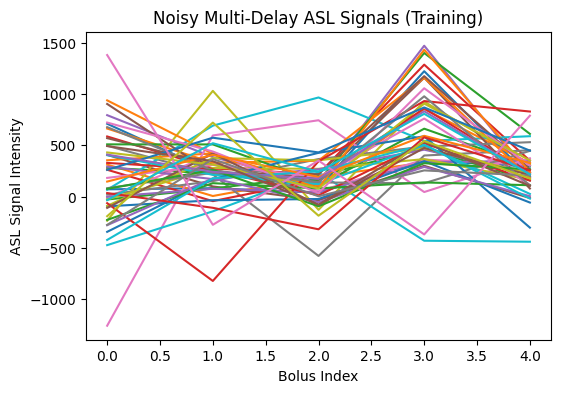

In [12]:
# Get ONE batch from the training loader
X_batch, y_cbf_batch, y_att_batch = next(iter(train_loader))

# Move to CPU for plotting
X_batch = X_batch.cpu().numpy()

plt.figure(figsize=(6,4))
plt.plot(X_batch[:50].T)
plt.xlabel("Bolus Index")
plt.ylabel("ASL Signal Intensity")
plt.title("Noisy Multi-Delay ASL Signals (Training)")
plt.show()


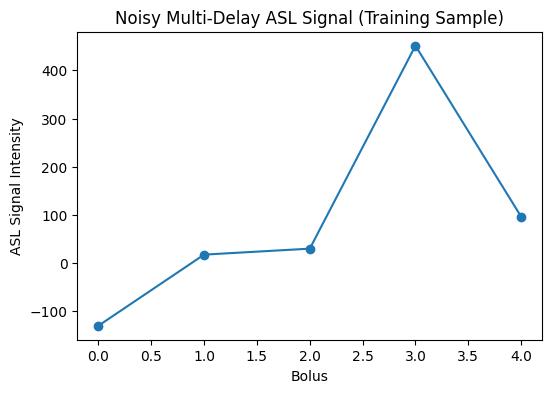

In [13]:
# Get one batch from the training loader
X_batch, y_cbf_batch, y_att_batch = next(iter(train_loader))

# Move to CPU for plotting
X_batch = X_batch.cpu().numpy()

idx = 0  # sample index inside the batch

plt.figure(figsize=(6,4))
plt.plot(X_batch[idx], marker='o')
plt.xlabel("Bolus")
plt.ylabel("ASL Signal Intensity")
plt.title("Noisy Multi-Delay ASL Signal (Training Sample)")
plt.show()


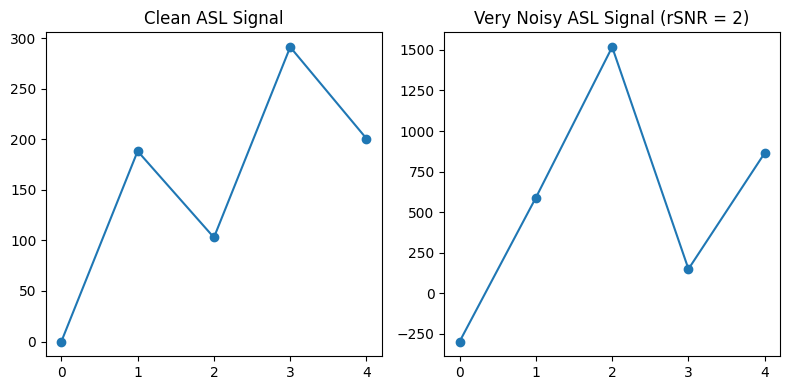

In [14]:
# Generate ONE clean signal for visualization only
CBF_vis = np.random.uniform(CBF_MIN, CBF_MAX, 1)
ATT_vis = np.random.uniform(ATT_MIN, ATT_MAX, 1)

X_clean_vis = asl_signal_paper(CBF_vis, ATT_vis, PLDs, LDs)

# Force very low rSNR = 2
low_rsnr = np.array([2.0])
X_very_noisy = add_rician_noise(X_clean_vis, low_rsnr)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(X_clean_vis[0], marker='o')
plt.title("Clean ASL Signal")

plt.subplot(1,2,2)
plt.plot(X_very_noisy[0], marker='o')
plt.title("Very Noisy ASL Signal (rSNR = 2)")

plt.tight_layout()
plt.show()


In [15]:
# -------------------------------
# Target normalization utilities
# -------------------------------

CBF_MIN, CBF_MAX = 20.0, 90.0
ATT_MIN, ATT_MAX = 500.0, 3000.0




In [16]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight) # He Initialization
        m.bias.data.fill_(0.01)

class IshidaNet(nn.Module):
    def __init__(self, L, N):
        super().__init__()
        layers = []
        # Input Layer: 5 inputs for the 5 ASL boluses [cite: 67, 196]
        layers.append(nn.Linear(5, N))
        layers.append(nn.ELU()) # Exponential Linear Unit as per paper [cite: 193]

        # Hidden Layers: Add L-1 additional hidden layers
        for _ in range(L - 1):
            layers.append(nn.Linear(N, N))
            layers.append(nn.ELU())

        # Output Layer: Single parameter (CBF or ATT) [cite: 193, 238]
        layers.append(nn.Linear(N, 1))
        self.net = nn.Sequential(*layers)
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight) # He Initialization
            nn.init.constant_(m.bias, 0.01)
    def forward(self, x):
      return self.net(x)


CBF_net = IshidaNet(L=9, N=8).to(device)
ATT_net = IshidaNet(L=8, N=256).to(device)

In [17]:
# Scale targets to [0, 1] range based on paper's ground truth ranges [cite: 70, 116, 117]
def normalize_targets(y, min_val, max_val):
    return (y - min_val) / (max_val - min_val)

def denormalize_targets(y_norm, min_val, max_val):
    return y_norm * (max_val - min_val) + min_val

# During training loop, use:
# loss = nn.MSELoss()(preds, normalize_targets(batch_y, MIN, MAX))

In [18]:
from tqdm import tqdm
import torch.nn as nn

def train_model(
    model,
    optimizer,
    train_loader,
    val_loader,
    target="cbf",      # "cbf" or "att"
    epochs=200
):
    train_losses, val_losses = [], []
    best_loss = float('inf')
    patience = 10
    trigger_times = 0

    for epoch in range(epochs):

        # --------------------
        # TRAINING
        # --------------------
        model.train()
        epoch_loss = 0.0

        train_bar = tqdm(
            train_loader,
            desc=f"Epoch {epoch+1}/{epochs} [TRAIN]",
            leave=False
        )

        for X, y_cbf, y_att in train_bar:
            X = X.to(device)
            y = y_cbf.to(device) if target == "cbf" else y_att.to(device)

            optimizer.zero_grad()
            preds = model(X)
            loss = nn.MSELoss()(preds, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # live batch loss
            train_bar.set_postfix(loss=loss.item())

        epoch_loss /= len(train_loader)

        # --------------------
        # VALIDATION
        # --------------------
        model.eval()
        val_loss = 0.0

        val_bar = tqdm(
            val_loader,
            desc=f"Epoch {epoch+1}/{epochs} [VAL]",
            leave=False
        )

        with torch.no_grad():
            for X, y_cbf, y_att in val_bar:
                X = X.to(device)
                y = y_cbf.to(device) if target == "cbf" else y_att.to(device)

                preds = model(X)
                loss = nn.MSELoss()(preds, y)
                val_loss += loss.item()

                val_bar.set_postfix(loss=loss.item())

        val_loss /= len(val_loader)

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)

        # --------------------
        # EPOCH SUMMARY
        # --------------------
        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {epoch_loss:.6f} | "
            f"Val Loss: {val_loss:.6f}"
        )

        # --------------------
        # EARLY STOPPING
        # --------------------
        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                model.load_state_dict(torch.load("best_model.pth"))
                break

    return train_losses, val_losses


In [19]:



optimizer_CBF = optim.Adam(CBF_net.parameters(), lr=1e-3)
optimizer_ATT = optim.Adam(ATT_net.parameters(), lr=1e-3)

# Train



In [20]:
print(IshidaNet)
print(IshidaNet.__dict__.get("forward", None))


<class '__main__.IshidaNet'>
<function IshidaNet.forward at 0x78c422346ca0>


In [ ]:
train_losses_CBF, val_losses_CBF = train_model(
    CBF_net,
    optimizer_CBF,
    train_loader,
    val_loader,
    target="cbf"
)


Epoch 1/200 [TRAIN]:  31%|███       | 381/1221 [05:29<12:04,  1.16it/s, loss=40.9]

In [ ]:
train_losses_ATT, val_losses_ATT = train_model(
    ATT_net,
    optimizer_ATT,
    train_loader,
    val_loader,
    target="att"
)


In [ ]:
CBF_net.eval()
ATT_net.eval()

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    CBF_pred = CBF_net(X_test_t).cpu().numpy().flatten()
    ATT_pred = ATT_net(X_test_t).cpu().numpy().flatten()




In [ ]:
plt.figure(figsize=(6,4))
plt.plot(train_losses_CBF, label="Train Loss (CBF)")
plt.plot(val_losses_CBF, label="Val Loss (CBF)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("CBF Network Training Curve")
plt.legend()
plt.show()


In [ ]:
def NMAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)) / np.mean(y_true)

def NRMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2)) / np.mean(y_true)


In [ ]:
CBF_gt = y_test[:, 0]
ATT_gt = y_test[:, 1]



In [ ]:
cbf_nmae = NMAE(CBF_gt, CBF_pred)
cbf_nrmse = NRMSE(CBF_gt, CBF_pred)

att_nmae = NMAE(ATT_gt, ATT_pred)
att_nrmse = NRMSE(ATT_gt, ATT_pred)

print("CBF  NMAE :", cbf_nmae)
print("CBF  NRMSE:", cbf_nrmse)
print("ATT  NMAE :", att_nmae)
print("ATT  NRMSE:", att_nrmse)


In [ ]:
def weighted_delay(asl_signal, PLDs):
    """
    asl_signal: (N, num_boluses)
    PLDs: array of delays (ms)
    """
    numerator = np.sum(asl_signal * PLDs, axis=1)
    denominator = np.sum(asl_signal, axis=1) + 1e-8
    return numerator / denominator


In [ ]:
ATT_grid = np.linspace(ATT_MIN, ATT_MAX, 200)
CBF_grid = np.linspace(CBF_MIN, CBF_MAX, 10)

wd_table = []

for att in ATT_grid:
    wd_vals = []

    for cbf in CBF_grid:
        sig = asl_signal_paper(
            np.array([cbf]),
            np.array([att]),
            PLDs,
            LDs
        )

        # NO NOISE — paper-correct
        wd = weighted_delay(sig, PLDs)
        wd_vals.append(wd[0])

    wd_table.append(np.mean(wd_vals))

wd_table = np.array(wd_table)


In [ ]:
def wd_to_att(wd_values, wd_table, ATT_grid):
    idx = np.abs(wd_table[None, :] - wd_values[:, None]).argmin(axis=1)
    return ATT_grid[idx]


In [ ]:
def estimate_cbf_ls(asl_signal, ATT_est):
    delta = ATT_est / 1000
    A = []

    for i in range(NUM_BOLUSES):
        w = PLDs[i] / 1000
        tau = LDs[i] / 1000

        coeff = np.exp(-delta / 1.66) * (
            np.exp(-np.maximum(w - delta, 0) / 1.2) -
            np.exp(-np.maximum(tau + w - delta, 0) / 1.2)
        )
        A.append(coeff)

    A = np.stack(A, axis=1)
    B = asl_signal

    return np.sum(A * B, axis=1) / (np.sum(A * A, axis=1) + 1e-8)


In [ ]:
# 1. Compute weighted delay on test data
WD_test = weighted_delay(X_test, PLDs)

# 2. Convert WD → ATT using lookup table
ATT_WD = wd_to_att(WD_test, wd_table, ATT_grid)

# 3. Reconstruct rSNR for test set
rSNR_test = np.repeat(rsnr_test, 10_000)

# 4. Low-SNR mask
low_snr_mask = rSNR_test < 6

# 5. Ground truth ATT (low SNR)
ATT_gt_low = ATT_gt[low_snr_mask]

# 6. WD-based ATT (low SNR)
ATT_WD_low = ATT_WD[low_snr_mask]

# 7. Compare WD vs DNN
print("WD ATT NRMSE (low rSNR):",
      NRMSE(ATT_gt_low, ATT_WD_low))

print("DNN ATT NRMSE (low rSNR):",
      NRMSE(ATT_gt_low, ATT_pred[low_snr_mask]))


In [ ]:
plt.figure(figsize=(6,4))
plt.plot(train_losses_ATT, label="Train Loss (ATT)")
plt.plot(val_losses_ATT, label="Val Loss (ATT)")
plt.legend()
plt.show()


In [ ]:
def plot_bland_altman(true, pred, title):
    mean = (true + pred) / 2
    diff = pred - true
    md = np.mean(diff)
    sd = np.std(diff)

    plt.figure(figsize=(8, 5))
    plt.scatter(mean, diff, alpha=0.1, s=2)
    plt.axhline(md, color='red', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.title(f"Bland-Altman: {title}")
    plt.xlabel("Mean of Ground Truth and Prediction")
    plt.ylabel("Difference (Pred - True)")
    plt.show()

# Run after re-training
plot_bland_altman(CBF_gt, CBF_pred.flatten(), "CBF Estimation")
plot_bland_altman(ATT_gt, ATT_pred.flatten(), "ATT Estimation")